## Spectral Quality

This notebook does some initial investigation of the GNPS library spectra (as collated by Justin & Florian)

Following steps:

- Load in the spectra from the mgf
- Find all pairs of spectra whose precursor mz is within 1Da (this is quite broad)
- Compute cosine similarities between all these pairs
- Then, for each spectrum compute:
  - (a) Number of peaks, square root-transformed. `n_peaks_sqrt`
  - (b) Arithmetic mean of the peak intensities, log-transformed. `a_mean`
  - (c) Standard deviation of the peak intensities, log-transformed. `a_std`
  - (d) Smallest m/z range containing 95% of the total peak intensity. `min_mz_range_95`
  - (e) Smallest m/z range containing 50% of the total peak intensity. `min_mz_range_50`
  - (f) Total ion current per m/z (total ion current divided by feature d), log-transformed. `tic_per_mz`
  - (g) Standard deviation of the consecutive m/z gaps between all peaks, log-transformed. `gap_std`
  - (h) Average number of neighbor peaks within a 2-Da interval around any peak. `neighbours_2da`
- For each spectrum, find the _second_ best spectral match (the first will be with itself)
- Record the cosine score for this match
- Plot this cosine score against each of these statistics to look for any obvious patterns

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import sys
mgf_file = 'allGNPS_positive_uniqueInchikey_191107.mgf'
sys.path.append('/Users/simon/git/spectral_quality/useful_code/')

## Load MGF

In [21]:
from utils import load_mgf
spectra = load_mgf(mgf_file,id_field = 'INCHIKEY')

Loaded 100 spectra
Loaded 200 spectra
Loaded 300 spectra
Loaded 400 spectra
Loaded 500 spectra
Loaded 600 spectra
Loaded 700 spectra
Loaded 800 spectra
Loaded 900 spectra
Loaded 1000 spectra
Loaded 1100 spectra
Loaded 1200 spectra
Loaded 1300 spectra
Loaded 1400 spectra
Loaded 1500 spectra
Loaded 1600 spectra
Loaded 1700 spectra
Loaded 1800 spectra
Loaded 1900 spectra
Loaded 2000 spectra
Loaded 2100 spectra
Loaded 2200 spectra
Loaded 2300 spectra
Loaded 2400 spectra
Loaded 2500 spectra
Loaded 2600 spectra
Loaded 2700 spectra
Loaded 2800 spectra
Loaded 2900 spectra
Loaded 3000 spectra
Loaded 3100 spectra
Loaded 3200 spectra
Loaded 3300 spectra
Loaded 3400 spectra
Loaded 3500 spectra
Loaded 3600 spectra
Loaded 3700 spectra
Loaded 3800 spectra
Loaded 3900 spectra
Loaded 4000 spectra
Loaded 4100 spectra
Loaded 4200 spectra
Loaded 4300 spectra
Loaded 4400 spectra
Loaded 4500 spectra
Loaded 4600 spectra
Loaded 4700 spectra
Loaded 4800 spectra
Loaded 4900 spectra
Loaded 5000 spectra
Loaded 51

In [31]:
# give the spectrum the inchikey...
for k,v in spectra.items():
    v.inchikey = k

## Put spectra into list and sort by `precursor_mz`

In [34]:
spec_list = list(spectra.values())
spec_list.sort(key = lambda x: x.precursor_mz)

## `spec_map` has each spectrum as a key and the value is a set containing all spectra within 1Da (including itself)

- Note: this is +-0.5

In [39]:
ms1_tol = 1 # wide
start_pos = 0
spec_map = {}
for i,spectrum in enumerate(spec_list):
    spec_map[spectrum] = set()
    while spec_list[start_pos].precursor_mz + ms1_tol/2 <= spectrum.precursor_mz:
        start_pos += 1
    temp_pos = start_pos
    while temp_pos < len(spec_list) and spec_list[temp_pos].precursor_mz <= spectrum.precursor_mz + ms1_tol/2:
        spec_map[spectrum].add(spec_list[temp_pos])
        temp_pos += 1

## Add sqrt normalised peaks to spectrum objects

In [45]:
from utils import sqrt_normalise
for spectrum in spec_list:
    spectrum.normalised_peaks = sqrt_normalise(spectrum.peaks)

## Compute cosinen score between each spectrum and the _partners_ (all others within 1Da)

In [50]:
from scoring_functions import fast_cosine
ms2_tol = 0.2
min_match = 1
spec_sim = {s:[] for s in spec_list}
n_done = 0
for spectrum,partners in spec_map.items():
    for partner in partners:
        score,_ = fast_cosine(spectrum,partner,ms2_tol,min_match)
        spec_sim[spectrum].append((partner,score))
    n_done += 1
    if n_done % 100 == 0:
        print(n_done)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000


## Sort the scores for each spectrum in descending order

In [117]:
# sort by score
for spectrum,partners in spec_sim.items():
    partners.sort(key = lambda x: x[1],reverse = True)

Now compute the following scores:

- (a) Number of peaks, square root-transformed. `n_peaks_sqrt`
- (b) Arithmetic mean of the peak intensities, log-transformed. `a_mean`
- (c) Standard deviation of the peak intensities, log-transformed. `a_std`
- (d) Smallest m/z range containing 95% of the total peak intensity. `min_mz_range_95`
- (e) Smallest m/z range containing 50% of the total peak intensity. `min_mz_range_50`
- (f) Total ion current per m/z (total ion current divided by feature d), log-transformed. `tic_per_mz`
- (g) Standard deviation of the consecutive m/z gaps between all peaks, log-transformed. `gap_std`
- (h) Average number of neighbor peaks within a 2-Da interval around any peak. `neighbours_2da`


In [ ]:
from utils import n_peaks_sqrt,a_mean,a_std
spec_meta = {s:{} for s in spec_list}

## Compute the first three stats

In [81]:
for s in spec_meta:
    spec_meta[s]['n_peaks_sqrt'] = n_peaks_sqrt(s)
    spec_meta[s]['a_mean'] = a_mean(s)
    spec_meta[s]['a_std'] = a_std(s)

Text(0, 0.5, 'Count')

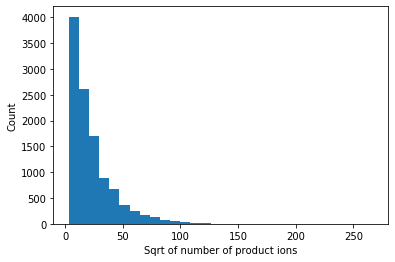

In [85]:
import pylab as plt
%matplotlib inline
h = plt.hist([v['n_peaks_sqrt'] for v in spec_meta.values()],bins=30)
plt.xlabel('Sqrt of number of product ions')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

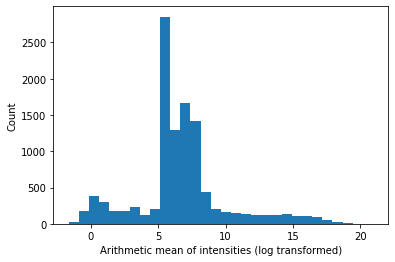

In [86]:
h = plt.hist([v['a_mean'] for v in spec_meta.values()],bins=30)
plt.xlabel('Arithmetic mean of intensities (log transformed)')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

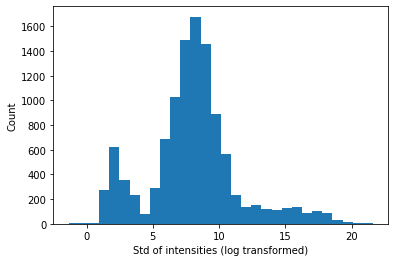

In [87]:
h = plt.hist([v['a_std'] for v in spec_meta.values()],bins=30)
plt.xlabel('Std of intensities (log transformed)')
plt.ylabel('Count')

## Compute the two mz range statistics (this takes a long time...)

In [80]:
from utils import smallest_mz_range
n_done = 0
for spectrum in spec_meta:
    a,b = smallest_mz_range(spectrum,0.5)
    c,d = smallest_mz_range(spectrum,0.95)
    spec_meta[spectrum]['min_mz_range_50'] = a
    spec_meta[spectrum]['min_mz_range_95'] = c
    n_done += 1
    if n_done % 100 == 0:
        print(n_done)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000


Text(0, 0.5, 'Count')

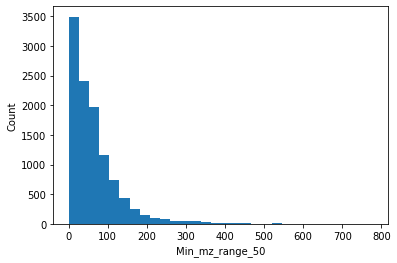

In [90]:
h = plt.hist([v['min_mz_range_50'] for v in spec_meta.values()],bins=30)
plt.xlabel('Min_mz_range_50')
plt.ylabel('Count')


Text(0, 0.5, 'Count')

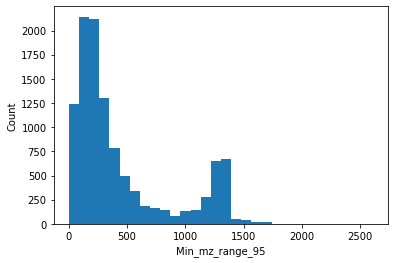

In [91]:
h = plt.hist([v['min_mz_range_95'] for v in spec_meta.values()],bins=30)
plt.xlabel('Min_mz_range_95')
plt.ylabel('Count')



## Compute the tic per mz (where mz range is the one for 95% intensity

In [99]:
import numpy as np
for spectrum in spec_meta:
    intensities = np.array([v[1] for v in spectrum.peaks])
    tot = intensities.sum()
    d = spec_meta[spectrum]['min_mz_range_95']
    if d == 0: # 95 is in one peak!
        d = 1
    spec_meta[spectrum]['tic_per_mz'] = np.log(tot / d)

Text(0, 0.5, 'Count')

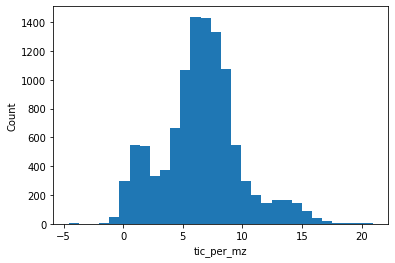

In [100]:
h = plt.hist([v['tic_per_mz'] for v in spec_meta.values()],bins=30)
plt.xlabel('tic_per_mz')
plt.ylabel('Count')

## Compute the std of the gaps in the spectra

In [118]:
from utils import gap_std
for spectrum in spec_meta:
    shifts = gap_std(spectrum)
    spec_meta[spectrum]['gap_std'] = shifts

Text(0, 0.5, 'Count')

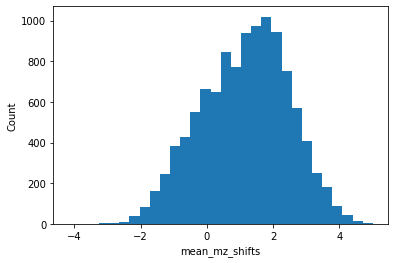

In [106]:
h = plt.hist([v['mean_mz_shifts'] for v in spec_meta.values()],bins=30)
plt.xlabel('mean_mz_shifts')
plt.ylabel('Count')

## Compute the average number of neighbours within 2Da of each peak (+-2Da)

In [116]:
from utils import n_neighbours
n_done = 0
for spectrum in spec_meta:
    m_n = n_neighbours(spectrum)
    spec_meta[spectrum]['neighbours_2da'] = m_n
    n_done += 1
    if n_done % 100 == 0:
        print(n_done)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000


## Find the score of the second highest scoring match for each spectrum

- Only keep spectra that have >1 score
- Also ignore the weird ones: there seem to be identical spectra assigned to different inchikeys

In [146]:
usable_spec = set() # those that have a spectral score with something other than themselves
for spectrum in spec_meta:
    # find its second highest cosine score
    ss = spec_sim[spectrum]
    if len(ss) == 1:
        continue
    ss.sort(key = lambda x: x[1],reverse = True)
    # top one should always be the true one
    if not ss[0][0] == spectrum:
        print(spectrum.inchikey,ss[0][0].inchikey)
        continue
    next_score = ss[1][1]
    spec_meta[spectrum]['next_score'] = next_score
    usable_spec.add(spectrum)

MVXMNHYVCLMLDD-UHFFFAOYSA-N HMRROBKAACRWBP-UHFFFAOYSA-N
HBUCPZGYBSEEHF-UHFFFAOYSA-N YIQGLTKAOHRZOL-UHFFFAOYSA-N
VZQSBJKDSWXLKX-UHFFFAOYSA-N PEYODCCEJQCEBL-UHFFFAOYSA-N
CKQJTGWITOTSIE-UHFFFAOYSA-N BRZLPCQEKPAETF-UHFFFAOYSA-N
ZMNXZIWMJCGGHP-UHFFFAOYSA-N SXXHPCVDFDABHW-UHFFFAOYSA-N
QKLPUVXBJHRFQZ-UHFFFAOYSA-N XOXHILFPRYWFOD-UHFFFAOYSA-N
BOWVQLFMWHZBEF-KTKRTIGZSA-N HXYVTAGFYLMHSO-UHFFFAOYSA-N
AVSXSVCZWQODGV-DPAQBDIFSA-N NYOXRYYXRWJDKP-GYKMGIIDSA-N
WHPZSYIEWQPEHY-OMZYKPILSA-N FHTSKUYELRWGGJ-PUDBDWLBSA-N
SDEURMLKLAEUAY-JFSPZUDSSA-N YAMUFBLWGFFICM-PTGWMXDISA-N


## Plot scatters of each of these scores versus the cosine difference

In [148]:
usable_spec = list(usable_spec)
x = [spec_meta[s]['next_score'] for s in usable_spec]

## Histogram of the second best scores

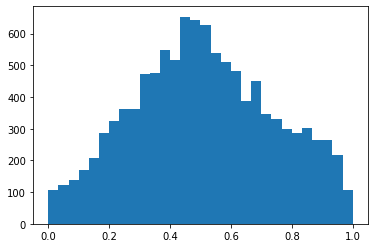

In [176]:
h = plt.hist(x,bins=30)

## Scatter plots of all other scores

Text(0, 0.5, 'n_peaks_sqrt')

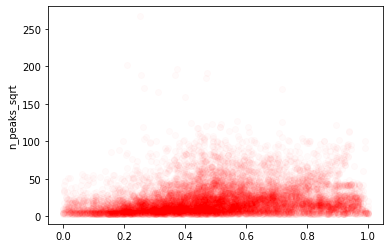

In [167]:
y = [spec_meta[s]['n_peaks_sqrt'] for s in usable_spec]
plt.plot(x,y,'ro',color=[1,0,0,0.02])
plt.ylabel('n_peaks_sqrt')

Text(0, 0.5, 'a_mean')

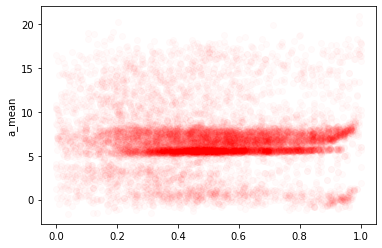

In [168]:
y = [spec_meta[s]['a_mean'] for s in usable_spec]
plt.plot(x,y,'ro',color=[1,0,0,0.02])
plt.ylabel('a_mean')

Text(0, 0.5, 'a_std')

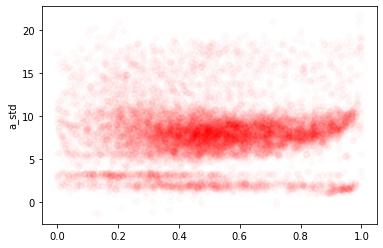

In [169]:
y = [spec_meta[s]['a_std'] for s in usable_spec]
plt.plot(x,y,'ro',color=[1,0,0,0.02])
plt.ylabel('a_std')

Text(0, 0.5, 'min_mz_range_95')

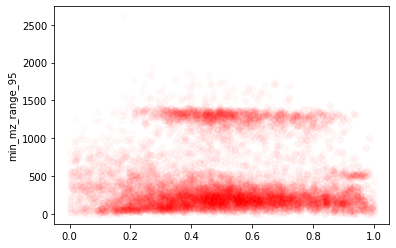

In [170]:
y = [spec_meta[s]['min_mz_range_95'] for s in usable_spec]
plt.plot(x,y,'ro',color=[1,0,0,0.02])
plt.ylabel('min_mz_range_95')

Text(0, 0.5, 'min_mz_range_50')

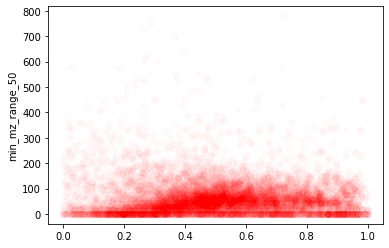

In [171]:
y = [spec_meta[s]['min_mz_range_50'] for s in usable_spec]
plt.plot(x,y,'ro',color=[1,0,0,0.02])
plt.ylabel('min_mz_range_50')

Text(0, 0.5, 'tic_per_mz')

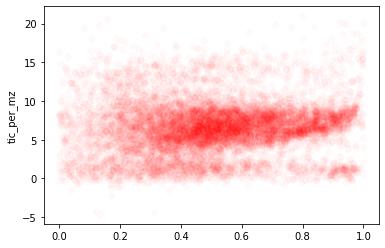

In [172]:
y = [spec_meta[s]['tic_per_mz'] for s in usable_spec]
plt.plot(x,y,'ro',color=[1,0,0,0.02])
plt.ylabel('tic_per_mz')

Text(0, 0.5, 'gap_std')

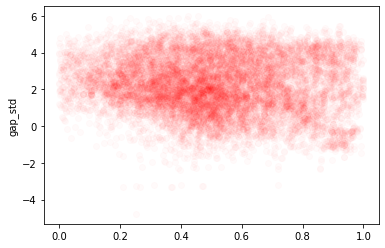

In [173]:
y = [spec_meta[s]['gap_std'] for s in usable_spec]
plt.plot(x,y,'ro',color=[1,0,0,0.02])
plt.ylabel('gap_std')

Text(0, 0.5, 'neighbours_2da')

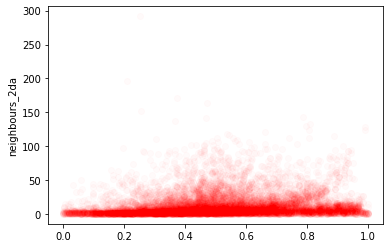

In [174]:
y = [spec_meta[s]['neighbours_2da'] for s in usable_spec]
plt.plot(x,y,'ro',color=[1,0,0,0.02])
plt.ylabel('neighbours_2da')